In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_targets_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 1576)
(463113, 1)
validation
(87055, 1576)
(87055, 1)
test
(43409, 1576)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2304001 (8.79 MB)


Trainable params: 2304001 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:10 - loss: 0.0228 - STD: 1.8298e-04 - MAE: 0.1332

 3/47 [>.............................] - ETA: 1s - loss: 0.0198 - STD: 2.8035e-04 - MAE: 0.1097  

 5/47 [==>...........................] - ETA: 1s - loss: 0.0202 - STD: 2.5729e-04 - MAE: 0.1082

 7/47 [===>..........................] - ETA: 1s - loss: 0.0185 - STD: 2.3154e-04 - MAE: 0.1020

 9/47 [====>.........................] - ETA: 1s - loss: 0.0174 - STD: 2.0949e-04 - MAE: 0.1008

11/47 [======>.......................] - ETA: 1s - loss: 0.0170 - STD: 1.9591e-04 - MAE: 0.1018

13/47 [=======>......................] - ETA: 1s - loss: 0.0163 - STD: 1.8766e-04 - MAE: 0.0999

15/47 [========>.....................] - ETA: 1s - loss: 0.0158 - STD: 1.8178e-04 - MAE: 0.0976

17/47 [=========>....................] - ETA: 1s - loss: 0.0156 - STD: 1.7728e-04 - MAE: 0.0961

19/47 [===========>..................] - ETA: 0s - loss: 0.0154 - STD: 1.7445e-04 - MAE: 0.0949

21/47 [============>.................] - ETA: 0s - loss: 0.0151 - STD: 1.7339e-04 - MAE: 0.0939

23/47 [=============>................] - ETA: 0s - loss: 0.0148 - STD: 1.7415e-04 - MAE: 0.0934

25/47 [==============>...............] - ETA: 0s - loss: 0.0147 - STD: 1.7580e-04 - MAE: 0.0933

27/47 [================>.............] - ETA: 0s - loss: 0.0145 - STD: 1.7766e-04 - MAE: 0.0930

29/47 [=================>............] - ETA: 0s - loss: 0.0143 - STD: 1.7953e-04 - MAE: 0.0924

31/47 [==================>...........] - ETA: 0s - loss: 0.0142 - STD: 1.8166e-04 - MAE: 0.0918

33/47 [====================>.........] - ETA: 0s - loss: 0.0141 - STD: 1.8380e-04 - MAE: 0.0913

35/47 [=====================>........] - ETA: 0s - loss: 0.0140 - STD: 1.8672e-04 - MAE: 0.0909

37/47 [======================>.......] - ETA: 0s - loss: 0.0139 - STD: 1.9023e-04 - MAE: 0.0905

39/47 [=======================>......] - ETA: 0s - loss: 0.0138 - STD: 1.9450e-04 - MAE: 0.0904

41/47 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 1.9902e-04 - MAE: 0.0902

43/47 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 2.0375e-04 - MAE: 0.0901

45/47 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 2.0820e-04 - MAE: 0.0898

47/47 [==============================] - ETA: 0s - loss: 0.0135 - STD: 2.1312e-04 - MAE: 0.0895

47/47 [==============================] - 5s 70ms/step - loss: 0.0135 - STD: 2.1312e-04 - MAE: 0.0895 - val_loss: 0.0143 - val_STD: 1.7797e-04 - val_MAE: 0.0919


Epoch 2/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0120 - STD: 3.3504e-04 - MAE: 0.0844

 3/47 [>.............................] - ETA: 1s - loss: 0.0120 - STD: 3.4508e-04 - MAE: 0.0843

 5/47 [==>...........................] - ETA: 1s - loss: 0.0121 - STD: 3.6217e-04 - MAE: 0.0850

 7/47 [===>..........................] - ETA: 1s - loss: 0.0119 - STD: 3.7406e-04 - MAE: 0.0850

 9/47 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 3.8487e-04 - MAE: 0.0854

11/47 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 3.9514e-04 - MAE: 0.0853

13/47 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 4.0630e-04 - MAE: 0.0852

15/47 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 4.1778e-04 - MAE: 0.0852

17/47 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 4.2920e-04 - MAE: 0.0850

19/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 4.4298e-04 - MAE: 0.0850

21/47 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 4.5703e-04 - MAE: 0.0850

23/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 4.7159e-04 - MAE: 0.0850

25/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 4.8622e-04 - MAE: 0.0850

28/47 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 5.1172e-04 - MAE: 0.0850

30/47 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 5.2999e-04 - MAE: 0.0850

32/47 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 5.4961e-04 - MAE: 0.0850

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 5.6978e-04 - MAE: 0.0850

36/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 5.8962e-04 - MAE: 0.0850

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 6.1160e-04 - MAE: 0.0850

40/47 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 6.3497e-04 - MAE: 0.0851

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 6.6049e-04 - MAE: 0.0851

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 6.8653e-04 - MAE: 0.0851

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 7.1370e-04 - MAE: 0.0851

47/47 [==============================] - 2s 42ms/step - loss: 0.0120 - STD: 7.2863e-04 - MAE: 0.0851 - val_loss: 0.0139 - val_STD: 8.0195e-04 - val_MAE: 0.0921


Epoch 3/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0120 - STD: 0.0015 - MAE: 0.0846

 3/47 [>.............................] - ETA: 1s - loss: 0.0120 - STD: 0.0015 - MAE: 0.0849

 5/47 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 0.0016 - MAE: 0.0851

 7/47 [===>..........................] - ETA: 1s - loss: 0.0120 - STD: 0.0017 - MAE: 0.0852

 9/47 [====>.........................] - ETA: 1s - loss: 0.0119 - STD: 0.0017 - MAE: 0.0852

11/47 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 0.0018 - MAE: 0.0853

13/47 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 0.0019 - MAE: 0.0854

15/47 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 0.0020 - MAE: 0.0854

17/47 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 0.0021 - MAE: 0.0853

19/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 0.0022 - MAE: 0.0852

21/47 [============>.................] - ETA: 0s - loss: 0.0119 - STD: 0.0023 - MAE: 0.0850

23/47 [=============>................] - ETA: 0s - loss: 0.0119 - STD: 0.0024 - MAE: 0.0850

25/47 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 0.0026 - MAE: 0.0850

27/47 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 0.0027 - MAE: 0.0849

29/47 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 0.0029 - MAE: 0.0848

31/47 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 0.0031 - MAE: 0.0847

33/47 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 0.0033 - MAE: 0.0847

35/47 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0035 - MAE: 0.0846

38/47 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0039 - MAE: 0.0845

40/47 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0042 - MAE: 0.0844

42/47 [=========================>....] - ETA: 0s - loss: 0.0118 - STD: 0.0045 - MAE: 0.0844

44/47 [===========================>..] - ETA: 0s - loss: 0.0117 - STD: 0.0048 - MAE: 0.0843

46/47 [============================>.] - ETA: 0s - loss: 0.0117 - STD: 0.0052 - MAE: 0.0841

47/47 [==============================] - 2s 42ms/step - loss: 0.0117 - STD: 0.0054 - MAE: 0.0841 - val_loss: 0.0131 - val_STD: 0.0100 - val_MAE: 0.0917


Epoch 4/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0116 - STD: 0.0155 - MAE: 0.0837

 3/47 [>.............................] - ETA: 1s - loss: 0.0112 - STD: 0.0164 - MAE: 0.0829

 5/47 [==>...........................] - ETA: 1s - loss: 0.0111 - STD: 0.0175 - MAE: 0.0823

 7/47 [===>..........................] - ETA: 1s - loss: 0.0109 - STD: 0.0184 - MAE: 0.0817

 9/47 [====>.........................] - ETA: 1s - loss: 0.0107 - STD: 0.0194 - MAE: 0.0812

11/47 [======>.......................] - ETA: 1s - loss: 0.0106 - STD: 0.0205 - MAE: 0.0808

13/47 [=======>......................] - ETA: 1s - loss: 0.0105 - STD: 0.0216 - MAE: 0.0803

15/47 [========>.....................] - ETA: 1s - loss: 0.0104 - STD: 0.0227 - MAE: 0.0797

17/47 [=========>....................] - ETA: 1s - loss: 0.0102 - STD: 0.0240 - MAE: 0.0792

19/47 [===========>..................] - ETA: 0s - loss: 0.0101 - STD: 0.0254 - MAE: 0.0788

21/47 [============>.................] - ETA: 0s - loss: 0.0100 - STD: 0.0268 - MAE: 0.0784

23/47 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 0.0283 - MAE: 0.0778

25/47 [==============>...............] - ETA: 0s - loss: 0.0098 - STD: 0.0299 - MAE: 0.0773

27/47 [================>.............] - ETA: 0s - loss: 0.0097 - STD: 0.0315 - MAE: 0.0770

29/47 [=================>............] - ETA: 0s - loss: 0.0096 - STD: 0.0333 - MAE: 0.0765

31/47 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 0.0350 - MAE: 0.0761

33/47 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 0.0365 - MAE: 0.0758

35/47 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0379 - MAE: 0.0753

37/47 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0392 - MAE: 0.0751

39/47 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0406 - MAE: 0.0749

41/47 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0414 - MAE: 0.0746

44/47 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0425 - MAE: 0.0746

46/47 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0435 - MAE: 0.0746

47/47 [==============================] - 2s 42ms/step - loss: 0.0093 - STD: 0.0436 - MAE: 0.0745 - val_loss: 0.0103 - val_STD: 0.0455 - val_MAE: 0.0759


Epoch 5/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0086 - STD: 0.0509 - MAE: 0.0670

 3/47 [>.............................] - ETA: 1s - loss: 0.0084 - STD: 0.0560 - MAE: 0.0717

 5/47 [==>...........................] - ETA: 1s - loss: 0.0085 - STD: 0.0537 - MAE: 0.0702

 8/47 [====>.........................] - ETA: 1s - loss: 0.0085 - STD: 0.0544 - MAE: 0.0707

10/47 [=====>........................] - ETA: 1s - loss: 0.0084 - STD: 0.0536 - MAE: 0.0700

12/47 [======>.......................] - ETA: 1s - loss: 0.0084 - STD: 0.0541 - MAE: 0.0702

14/47 [=======>......................] - ETA: 1s - loss: 0.0083 - STD: 0.0538 - MAE: 0.0699

16/47 [=========>....................] - ETA: 1s - loss: 0.0082 - STD: 0.0541 - MAE: 0.0696

18/47 [==========>...................] - ETA: 0s - loss: 0.0082 - STD: 0.0544 - MAE: 0.0696

20/47 [===========>..................] - ETA: 0s - loss: 0.0082 - STD: 0.0546 - MAE: 0.0693

22/47 [=============>................] - ETA: 0s - loss: 0.0081 - STD: 0.0552 - MAE: 0.0692

24/47 [==============>...............] - ETA: 0s - loss: 0.0081 - STD: 0.0555 - MAE: 0.0690

26/47 [===============>..............] - ETA: 0s - loss: 0.0081 - STD: 0.0561 - MAE: 0.0691

28/47 [================>.............] - ETA: 0s - loss: 0.0081 - STD: 0.0564 - MAE: 0.0689

30/47 [==================>...........] - ETA: 0s - loss: 0.0081 - STD: 0.0570 - MAE: 0.0689

32/47 [===================>..........] - ETA: 0s - loss: 0.0080 - STD: 0.0573 - MAE: 0.0687

34/47 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.0578 - MAE: 0.0686

36/47 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0582 - MAE: 0.0685

38/47 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0586 - MAE: 0.0685

40/47 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0589 - MAE: 0.0684

42/47 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0593 - MAE: 0.0683

44/47 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0596 - MAE: 0.0682

46/47 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.0599 - MAE: 0.0682

47/47 [==============================] - 2s 42ms/step - loss: 0.0080 - STD: 0.0600 - MAE: 0.0681 - val_loss: 0.0093 - val_STD: 0.0578 - val_MAE: 0.0755


Epoch 6/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0078 - STD: 0.0660 - MAE: 0.0671

 3/47 [>.............................] - ETA: 1s - loss: 0.0078 - STD: 0.0652 - MAE: 0.0669

 5/47 [==>...........................] - ETA: 1s - loss: 0.0078 - STD: 0.0655 - MAE: 0.0670

 7/47 [===>..........................] - ETA: 1s - loss: 0.0078 - STD: 0.0650 - MAE: 0.0666

 9/47 [====>.........................] - ETA: 1s - loss: 0.0078 - STD: 0.0652 - MAE: 0.0670

11/47 [======>.......................] - ETA: 1s - loss: 0.0078 - STD: 0.0648 - MAE: 0.0668

13/47 [=======>......................] - ETA: 1s - loss: 0.0078 - STD: 0.0648 - MAE: 0.0669

15/47 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.0646 - MAE: 0.0668

17/47 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.0646 - MAE: 0.0668

19/47 [===========>..................] - ETA: 0s - loss: 0.0077 - STD: 0.0645 - MAE: 0.0667

21/47 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.0644 - MAE: 0.0666

23/47 [=============>................] - ETA: 0s - loss: 0.0077 - STD: 0.0643 - MAE: 0.0666

25/47 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0643 - MAE: 0.0666

27/47 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0644 - MAE: 0.0666

29/47 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0644 - MAE: 0.0666

31/47 [==================>...........] - ETA: 0s - loss: 0.0077 - STD: 0.0644 - MAE: 0.0667

34/47 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.0645 - MAE: 0.0665

36/47 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.0646 - MAE: 0.0665

38/47 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.0646 - MAE: 0.0665

40/47 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0646 - MAE: 0.0665

42/47 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0647 - MAE: 0.0665

44/47 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0647 - MAE: 0.0665

46/47 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.0647 - MAE: 0.0665

47/47 [==============================] - 2s 41ms/step - loss: 0.0077 - STD: 0.0648 - MAE: 0.0665 - val_loss: 0.0094 - val_STD: 0.0555 - val_MAE: 0.0743


Epoch 7/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0080 - STD: 0.0642 - MAE: 0.0664

 3/47 [>.............................] - ETA: 1s - loss: 0.0078 - STD: 0.0648 - MAE: 0.0667

 5/47 [==>...........................] - ETA: 1s - loss: 0.0077 - STD: 0.0644 - MAE: 0.0662

 7/47 [===>..........................] - ETA: 1s - loss: 0.0077 - STD: 0.0648 - MAE: 0.0666

 9/47 [====>.........................] - ETA: 1s - loss: 0.0077 - STD: 0.0647 - MAE: 0.0662

11/47 [======>.......................] - ETA: 1s - loss: 0.0077 - STD: 0.0649 - MAE: 0.0663

13/47 [=======>......................] - ETA: 1s - loss: 0.0076 - STD: 0.0649 - MAE: 0.0662

15/47 [========>.....................] - ETA: 1s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0662

17/47 [=========>....................] - ETA: 1s - loss: 0.0076 - STD: 0.0649 - MAE: 0.0660

19/47 [===========>..................] - ETA: 0s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0661

21/47 [============>.................] - ETA: 0s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0660

23/47 [=============>................] - ETA: 0s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0660

25/47 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0660

27/47 [================>.............] - ETA: 0s - loss: 0.0076 - STD: 0.0651 - MAE: 0.0660

29/47 [=================>............] - ETA: 0s - loss: 0.0076 - STD: 0.0651 - MAE: 0.0660

31/47 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0652 - MAE: 0.0660

33/47 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0652 - MAE: 0.0660

35/47 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0653 - MAE: 0.0661

37/47 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0653 - MAE: 0.0660

39/47 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0654 - MAE: 0.0660

41/47 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0654 - MAE: 0.0660

43/47 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0654 - MAE: 0.0660

46/47 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0654 - MAE: 0.0660

47/47 [==============================] - 2s 41ms/step - loss: 0.0076 - STD: 0.0654 - MAE: 0.0660 - val_loss: 0.0096 - val_STD: 0.0545 - val_MAE: 0.0738


Epoch 8/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.0624 - MAE: 0.0648

 3/47 [>.............................] - ETA: 1s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0660

 5/47 [==>...........................] - ETA: 1s - loss: 0.0076 - STD: 0.0640 - MAE: 0.0655

 7/47 [===>..........................] - ETA: 1s - loss: 0.0076 - STD: 0.0643 - MAE: 0.0660

 9/47 [====>.........................] - ETA: 1s - loss: 0.0076 - STD: 0.0642 - MAE: 0.0660

11/47 [======>.......................] - ETA: 1s - loss: 0.0077 - STD: 0.0642 - MAE: 0.0661

13/47 [=======>......................] - ETA: 1s - loss: 0.0077 - STD: 0.0643 - MAE: 0.0663

15/47 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.0639 - MAE: 0.0661

17/47 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.0641 - MAE: 0.0662

19/47 [===========>..................] - ETA: 0s - loss: 0.0077 - STD: 0.0640 - MAE: 0.0661

21/47 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.0640 - MAE: 0.0661

23/47 [=============>................] - ETA: 0s - loss: 0.0077 - STD: 0.0640 - MAE: 0.0661

25/47 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0641 - MAE: 0.0661

27/47 [================>.............] - ETA: 0s - loss: 0.0076 - STD: 0.0642 - MAE: 0.0661

29/47 [=================>............] - ETA: 0s - loss: 0.0076 - STD: 0.0643 - MAE: 0.0661

31/47 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0644 - MAE: 0.0660

34/47 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0645 - MAE: 0.0660

36/47 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0647 - MAE: 0.0660

38/47 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0647 - MAE: 0.0659

40/47 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0648 - MAE: 0.0659

42/47 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0649 - MAE: 0.0659

44/47 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0659

46/47 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0651 - MAE: 0.0659

47/47 [==============================] - 2s 42ms/step - loss: 0.0076 - STD: 0.0651 - MAE: 0.0659 - val_loss: 0.0094 - val_STD: 0.0578 - val_MAE: 0.0737


Epoch 9/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.0661 - MAE: 0.0653

 3/47 [>.............................] - ETA: 1s - loss: 0.0076 - STD: 0.0668 - MAE: 0.0655

 5/47 [==>...........................] - ETA: 1s - loss: 0.0075 - STD: 0.0667 - MAE: 0.0654

 7/47 [===>..........................] - ETA: 1s - loss: 0.0075 - STD: 0.0666 - MAE: 0.0653

 9/47 [====>.........................] - ETA: 1s - loss: 0.0075 - STD: 0.0664 - MAE: 0.0652

11/47 [======>.......................] - ETA: 1s - loss: 0.0075 - STD: 0.0665 - MAE: 0.0654

13/47 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.0664 - MAE: 0.0653

15/47 [========>.....................] - ETA: 1s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0653

17/47 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.0664 - MAE: 0.0654

19/47 [===========>..................] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0652

21/47 [============>.................] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0652

23/47 [=============>................] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0653

25/47 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0653

27/47 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0652

29/47 [=================>............] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0653

31/47 [==================>...........] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0653

33/47 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0662 - MAE: 0.0652

35/47 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0663 - MAE: 0.0653

37/47 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0662 - MAE: 0.0654

39/47 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0662 - MAE: 0.0653

41/47 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0662 - MAE: 0.0653

43/47 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0662 - MAE: 0.0653

46/47 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0662 - MAE: 0.0653

47/47 [==============================] - 2s 42ms/step - loss: 0.0075 - STD: 0.0662 - MAE: 0.0652 - val_loss: 0.0092 - val_STD: 0.0602 - val_MAE: 0.0750


Epoch 10/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.0682 - MAE: 0.0672

 3/47 [>.............................] - ETA: 1s - loss: 0.0075 - STD: 0.0666 - MAE: 0.0649

 5/47 [==>...........................] - ETA: 1s - loss: 0.0075 - STD: 0.0668 - MAE: 0.0650

 7/47 [===>..........................] - ETA: 1s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0651

 9/47 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.0662 - MAE: 0.0648

11/47 [======>.......................] - ETA: 1s - loss: 0.0075 - STD: 0.0661 - MAE: 0.0650

14/47 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.0659 - MAE: 0.0651

16/47 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.0659 - MAE: 0.0652

18/47 [==========>...................] - ETA: 0s - loss: 0.0074 - STD: 0.0659 - MAE: 0.0650

20/47 [===========>..................] - ETA: 0s - loss: 0.0074 - STD: 0.0659 - MAE: 0.0650

22/47 [=============>................] - ETA: 0s - loss: 0.0074 - STD: 0.0660 - MAE: 0.0649

24/47 [==============>...............] - ETA: 0s - loss: 0.0074 - STD: 0.0661 - MAE: 0.0649

26/47 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0662 - MAE: 0.0650

28/47 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0663 - MAE: 0.0650

30/47 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0664 - MAE: 0.0650

32/47 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0665 - MAE: 0.0650

34/47 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0665 - MAE: 0.0650

36/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0650

38/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0649

40/47 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0665 - MAE: 0.0649

42/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0649

44/47 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0649

46/47 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0649

47/47 [==============================] - 2s 42ms/step - loss: 0.0074 - STD: 0.0666 - MAE: 0.0649 - val_loss: 0.0093 - val_STD: 0.0592 - val_MAE: 0.0738


Epoch 11/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0071 - STD: 0.0669 - MAE: 0.0634

 3/47 [>.............................] - ETA: 1s - loss: 0.0073 - STD: 0.0675 - MAE: 0.0646

 5/47 [==>...........................] - ETA: 1s - loss: 0.0074 - STD: 0.0675 - MAE: 0.0647

 7/47 [===>..........................] - ETA: 1s - loss: 0.0073 - STD: 0.0672 - MAE: 0.0643

 9/47 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.0671 - MAE: 0.0643

11/47 [======>.......................] - ETA: 1s - loss: 0.0074 - STD: 0.0670 - MAE: 0.0644

14/47 [=======>......................] - ETA: 1s - loss: 0.0074 - STD: 0.0669 - MAE: 0.0645

16/47 [=========>....................] - ETA: 1s - loss: 0.0074 - STD: 0.0667 - MAE: 0.0644

18/47 [==========>...................] - ETA: 0s - loss: 0.0074 - STD: 0.0668 - MAE: 0.0646

20/47 [===========>..................] - ETA: 0s - loss: 0.0074 - STD: 0.0667 - MAE: 0.0646

22/47 [=============>................] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0645

24/47 [==============>...............] - ETA: 0s - loss: 0.0074 - STD: 0.0667 - MAE: 0.0646

26/47 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.0668 - MAE: 0.0646

28/47 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0669 - MAE: 0.0646

30/47 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0670 - MAE: 0.0646

32/47 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0670 - MAE: 0.0645

34/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0671 - MAE: 0.0645

36/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0670 - MAE: 0.0645

38/47 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0671 - MAE: 0.0644

40/47 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0671 - MAE: 0.0644

42/47 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0671 - MAE: 0.0644

44/47 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0672 - MAE: 0.0643

46/47 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0672 - MAE: 0.0643

47/47 [==============================] - 2s 41ms/step - loss: 0.0073 - STD: 0.0673 - MAE: 0.0644 - val_loss: 0.0106 - val_STD: 0.0548 - val_MAE: 0.0753


Epoch 12/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0083 - STD: 0.0605 - MAE: 0.0652

 3/47 [>.............................] - ETA: 1s - loss: 0.0078 - STD: 0.0655 - MAE: 0.0661

 5/47 [==>...........................] - ETA: 1s - loss: 0.0077 - STD: 0.0662 - MAE: 0.0661

 7/47 [===>..........................] - ETA: 1s - loss: 0.0077 - STD: 0.0651 - MAE: 0.0657

 9/47 [====>.........................] - ETA: 1s - loss: 0.0077 - STD: 0.0643 - MAE: 0.0654

11/47 [======>.......................] - ETA: 1s - loss: 0.0076 - STD: 0.0643 - MAE: 0.0654

13/47 [=======>......................] - ETA: 1s - loss: 0.0076 - STD: 0.0639 - MAE: 0.0653

15/47 [========>.....................] - ETA: 1s - loss: 0.0075 - STD: 0.0637 - MAE: 0.0652

17/47 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.0640 - MAE: 0.0653

19/47 [===========>..................] - ETA: 0s - loss: 0.0075 - STD: 0.0642 - MAE: 0.0653

21/47 [============>.................] - ETA: 0s - loss: 0.0075 - STD: 0.0644 - MAE: 0.0652

24/47 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0649 - MAE: 0.0650

26/47 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0652 - MAE: 0.0650

28/47 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.0654 - MAE: 0.0649

30/47 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0657 - MAE: 0.0648

32/47 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0659 - MAE: 0.0647

34/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0661 - MAE: 0.0646

36/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0663 - MAE: 0.0645

38/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0665 - MAE: 0.0645

40/47 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0667 - MAE: 0.0646

42/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0646

44/47 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0645

46/47 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0645

47/47 [==============================] - 2s 42ms/step - loss: 0.0074 - STD: 0.0666 - MAE: 0.0644 - val_loss: 0.0092 - val_STD: 0.0603 - val_MAE: 0.0729


Epoch 13/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.0658 - MAE: 0.0636

 4/47 [=>............................] - ETA: 1s - loss: 0.0072 - STD: 0.0667 - MAE: 0.0636

 6/47 [==>...........................] - ETA: 1s - loss: 0.0072 - STD: 0.0671 - MAE: 0.0634

 8/47 [====>.........................] - ETA: 1s - loss: 0.0072 - STD: 0.0675 - MAE: 0.0633

10/47 [=====>........................] - ETA: 1s - loss: 0.0072 - STD: 0.0678 - MAE: 0.0635

12/47 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.0682 - MAE: 0.0634

14/47 [=======>......................] - ETA: 1s - loss: 0.0072 - STD: 0.0683 - MAE: 0.0636

16/47 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.0682 - MAE: 0.0638

18/47 [==========>...................] - ETA: 0s - loss: 0.0073 - STD: 0.0681 - MAE: 0.0638

20/47 [===========>..................] - ETA: 0s - loss: 0.0073 - STD: 0.0680 - MAE: 0.0637

22/47 [=============>................] - ETA: 0s - loss: 0.0073 - STD: 0.0680 - MAE: 0.0638

24/47 [==============>...............] - ETA: 0s - loss: 0.0073 - STD: 0.0681 - MAE: 0.0640

26/47 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.0679 - MAE: 0.0642

28/47 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.0676 - MAE: 0.0641

30/47 [==================>...........] - ETA: 0s - loss: 0.0073 - STD: 0.0674 - MAE: 0.0641

32/47 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.0673 - MAE: 0.0642

34/47 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0670 - MAE: 0.0641

36/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0668 - MAE: 0.0643

38/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0669 - MAE: 0.0644

40/47 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0667 - MAE: 0.0644

42/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0665 - MAE: 0.0647

44/47 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0664 - MAE: 0.0649

46/47 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0660 - MAE: 0.0648

47/47 [==============================] - 2s 42ms/step - loss: 0.0075 - STD: 0.0659 - MAE: 0.0649 - val_loss: 0.0098 - val_STD: 0.0582 - val_MAE: 0.0802


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0080 - STD: 0.0631 - MAE: 0.0712

 3/47 [>.............................] - ETA: 1s - loss: 0.0076 - STD: 0.0583 - MAE: 0.0653

 5/47 [==>...........................] - ETA: 1s - loss: 0.0075 - STD: 0.0602 - MAE: 0.0660

 7/47 [===>..........................] - ETA: 1s - loss: 0.0075 - STD: 0.0601 - MAE: 0.0653

10/47 [=====>........................] - ETA: 1s - loss: 0.0075 - STD: 0.0617 - MAE: 0.0653

12/47 [======>.......................] - ETA: 1s - loss: 0.0074 - STD: 0.0629 - MAE: 0.0651

14/47 [=======>......................] - ETA: 1s - loss: 0.0074 - STD: 0.0636 - MAE: 0.0649

16/47 [=========>....................] - ETA: 1s - loss: 0.0073 - STD: 0.0644 - MAE: 0.0647

18/47 [==========>...................] - ETA: 0s - loss: 0.0073 - STD: 0.0651 - MAE: 0.0645

20/47 [===========>..................] - ETA: 0s - loss: 0.0073 - STD: 0.0656 - MAE: 0.0643

22/47 [=============>................] - ETA: 0s - loss: 0.0073 - STD: 0.0661 - MAE: 0.0642

24/47 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.0663 - MAE: 0.0640

26/47 [===============>..............] - ETA: 0s - loss: 0.0072 - STD: 0.0666 - MAE: 0.0639

28/47 [================>.............] - ETA: 0s - loss: 0.0072 - STD: 0.0668 - MAE: 0.0639

30/47 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0669 - MAE: 0.0638

32/47 [===================>..........] - ETA: 0s - loss: 0.0072 - STD: 0.0670 - MAE: 0.0637

34/47 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0671 - MAE: 0.0637

36/47 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0672 - MAE: 0.0636

38/47 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0674 - MAE: 0.0636

40/47 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0674 - MAE: 0.0635

42/47 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0675 - MAE: 0.0635

44/47 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0676 - MAE: 0.0635

46/47 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0676 - MAE: 0.0635

47/47 [==============================] - 2s 41ms/step - loss: 0.0072 - STD: 0.0677 - MAE: 0.0635 - val_loss: 0.0096 - val_STD: 0.0604 - val_MAE: 0.0725


Epoch 15/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0074 - STD: 0.0635 - MAE: 0.0622

 3/47 [>.............................] - ETA: 1s - loss: 0.0073 - STD: 0.0676 - MAE: 0.0640

 5/47 [==>...........................] - ETA: 1s - loss: 0.0072 - STD: 0.0670 - MAE: 0.0631

 7/47 [===>..........................] - ETA: 1s - loss: 0.0072 - STD: 0.0668 - MAE: 0.0632

 9/47 [====>.........................] - ETA: 1s - loss: 0.0072 - STD: 0.0674 - MAE: 0.0637

11/47 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.0669 - MAE: 0.0633

13/47 [=======>......................] - ETA: 1s - loss: 0.0072 - STD: 0.0673 - MAE: 0.0635

15/47 [========>.....................] - ETA: 1s - loss: 0.0072 - STD: 0.0674 - MAE: 0.0634

18/47 [==========>...................] - ETA: 0s - loss: 0.0071 - STD: 0.0679 - MAE: 0.0633

20/47 [===========>..................] - ETA: 0s - loss: 0.0071 - STD: 0.0680 - MAE: 0.0632

22/47 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0682 - MAE: 0.0631

24/47 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0684 - MAE: 0.0630

26/47 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0686 - MAE: 0.0629

28/47 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.0687 - MAE: 0.0628

30/47 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.0689 - MAE: 0.0628

32/47 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0690 - MAE: 0.0627

34/47 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0691 - MAE: 0.0626

36/47 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0691 - MAE: 0.0626

38/47 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0693 - MAE: 0.0626

40/47 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0693 - MAE: 0.0626

42/47 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0693 - MAE: 0.0626

44/47 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0694 - MAE: 0.0625

46/47 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0694 - MAE: 0.0625

47/47 [==============================] - 2s 41ms/step - loss: 0.0070 - STD: 0.0695 - MAE: 0.0625 - val_loss: 0.0094 - val_STD: 0.0647 - val_MAE: 0.0722


Epoch 16/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0077 - STD: 0.0672 - MAE: 0.0632

 3/47 [>.............................] - ETA: 1s - loss: 0.0072 - STD: 0.0697 - MAE: 0.0631

 5/47 [==>...........................] - ETA: 1s - loss: 0.0070 - STD: 0.0703 - MAE: 0.0626

 7/47 [===>..........................] - ETA: 1s - loss: 0.0070 - STD: 0.0703 - MAE: 0.0626

 9/47 [====>.........................] - ETA: 1s - loss: 0.0070 - STD: 0.0700 - MAE: 0.0623

11/47 [======>.......................] - ETA: 1s - loss: 0.0070 - STD: 0.0699 - MAE: 0.0623

13/47 [=======>......................] - ETA: 1s - loss: 0.0070 - STD: 0.0700 - MAE: 0.0625

15/47 [========>.....................] - ETA: 1s - loss: 0.0070 - STD: 0.0699 - MAE: 0.0624

17/47 [=========>....................] - ETA: 1s - loss: 0.0070 - STD: 0.0699 - MAE: 0.0623

19/47 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0699 - MAE: 0.0622

21/47 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.0700 - MAE: 0.0622

23/47 [=============>................] - ETA: 0s - loss: 0.0069 - STD: 0.0702 - MAE: 0.0622

25/47 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0621

28/47 [================>.............] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0621

30/47 [==================>...........] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0622

32/47 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0703 - MAE: 0.0623

34/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0622

36/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0702 - MAE: 0.0622

38/47 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0702 - MAE: 0.0621

40/47 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0621

42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0621

44/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0702 - MAE: 0.0621

46/47 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0621

47/47 [==============================] - 2s 41ms/step - loss: 0.0069 - STD: 0.0702 - MAE: 0.0621 - val_loss: 0.0092 - val_STD: 0.0707 - val_MAE: 0.0729


Epoch 17/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0065 - STD: 0.0717 - MAE: 0.0609

 3/47 [>.............................] - ETA: 1s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0609

 5/47 [==>...........................] - ETA: 1s - loss: 0.0066 - STD: 0.0726 - MAE: 0.0611

 7/47 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0611

 9/47 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0613

11/47 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.0719 - MAE: 0.0614

13/47 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0717 - MAE: 0.0612

15/47 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0611

17/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0612

19/47 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0717 - MAE: 0.0613

21/47 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0614

23/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0716 - MAE: 0.0614

25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0614

27/47 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0614

29/47 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0615

32/47 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0618

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0710 - MAE: 0.0618

36/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0707 - MAE: 0.0619

38/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0708 - MAE: 0.0619

40/47 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0708 - MAE: 0.0619

42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0709 - MAE: 0.0619

44/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0708 - MAE: 0.0619

46/47 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0709 - MAE: 0.0619

47/47 [==============================] - 2s 41ms/step - loss: 0.0069 - STD: 0.0709 - MAE: 0.0619 - val_loss: 0.0094 - val_STD: 0.0730 - val_MAE: 0.0737


Epoch 18/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0066 - STD: 0.0726 - MAE: 0.0617

 3/47 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.0717 - MAE: 0.0618

 5/47 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.0711 - MAE: 0.0615

 7/47 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0712 - MAE: 0.0611

 9/47 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0611

11/47 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0719 - MAE: 0.0610

13/47 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0610

16/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0614

18/47 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0717 - MAE: 0.0615

20/47 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0615

22/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0615

24/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0715 - MAE: 0.0615

26/47 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0717 - MAE: 0.0616

28/47 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0615

30/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0614

32/47 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0614

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0614

36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0718 - MAE: 0.0613

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0719 - MAE: 0.0612

40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0612

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0722 - MAE: 0.0612

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0722 - MAE: 0.0612

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0612

47/47 [==============================] - 2s 42ms/step - loss: 0.0067 - STD: 0.0720 - MAE: 0.0612 - val_loss: 0.0095 - val_STD: 0.0760 - val_MAE: 0.0743


Epoch 19/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0069 - STD: 0.0738 - MAE: 0.0629

 3/47 [>.............................] - ETA: 1s - loss: 0.0067 - STD: 0.0709 - MAE: 0.0614

 5/47 [==>...........................] - ETA: 1s - loss: 0.0066 - STD: 0.0713 - MAE: 0.0607

 7/47 [===>..........................] - ETA: 1s - loss: 0.0066 - STD: 0.0727 - MAE: 0.0607

 9/47 [====>.........................] - ETA: 1s - loss: 0.0066 - STD: 0.0734 - MAE: 0.0607

11/47 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0608

13/47 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0729 - MAE: 0.0610

15/47 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0722 - MAE: 0.0610

17/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0718 - MAE: 0.0611

19/47 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0614

21/47 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0719 - MAE: 0.0614

23/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0720 - MAE: 0.0615

25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0615

27/47 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0717 - MAE: 0.0615

29/47 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0719 - MAE: 0.0615

31/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0720 - MAE: 0.0615

33/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0721 - MAE: 0.0614

36/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0721 - MAE: 0.0614

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0612

40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0612

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0722 - MAE: 0.0611

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0723 - MAE: 0.0611

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0723 - MAE: 0.0610

47/47 [==============================] - 2s 41ms/step - loss: 0.0067 - STD: 0.0724 - MAE: 0.0610 - val_loss: 0.0093 - val_STD: 0.0789 - val_MAE: 0.0726


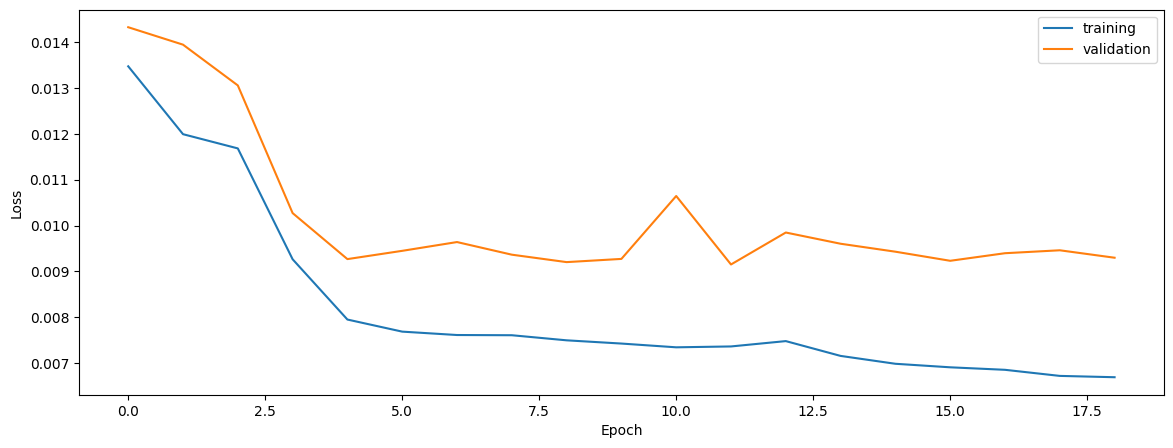

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6389998515136252
0.5832091901015356
0.5891075704916597


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6283767187101614
0.6339849200730181
0.6014050886186801


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.634376380662399
0.6384953477331963
0.6205592142346401


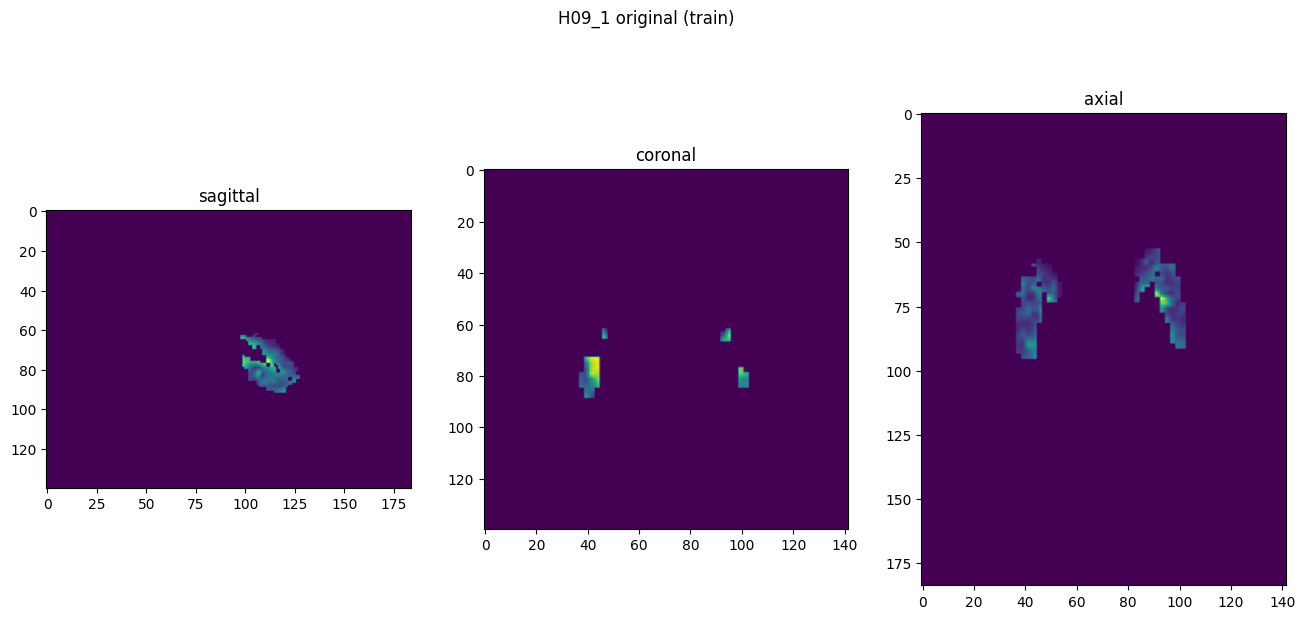

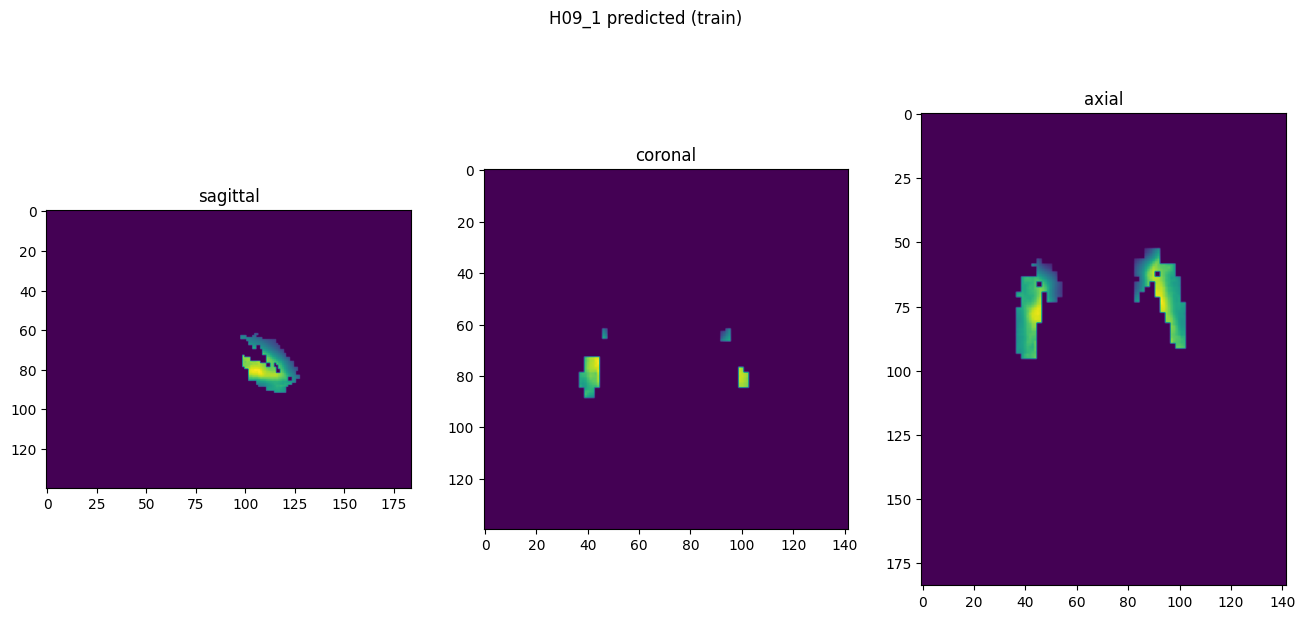

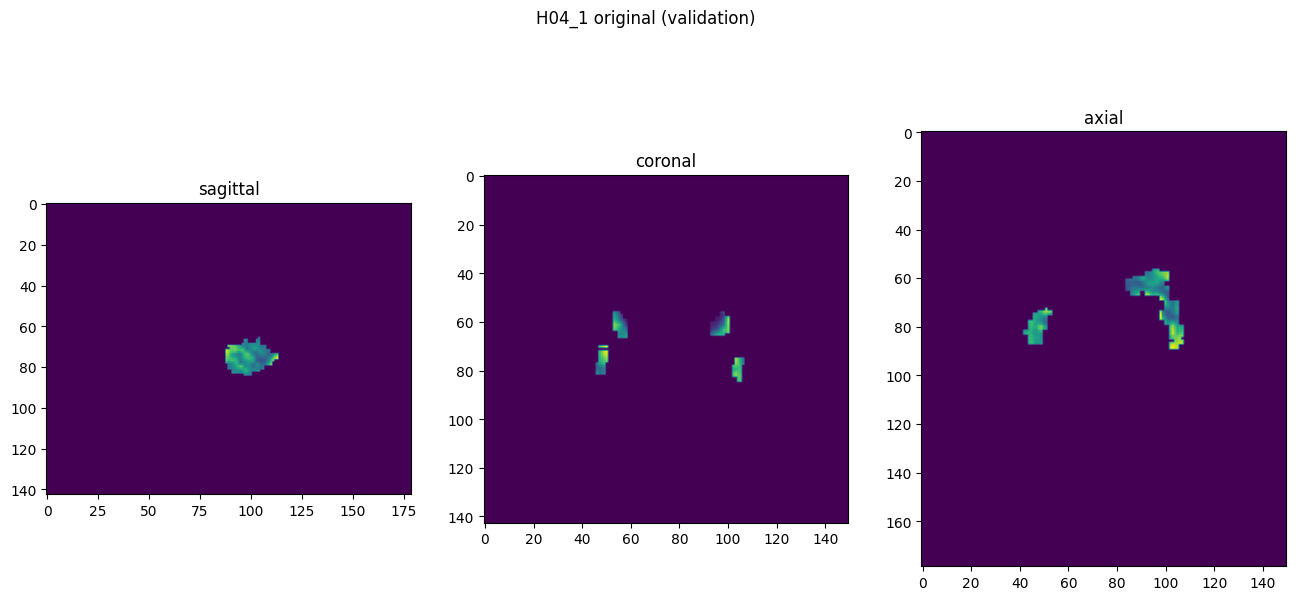

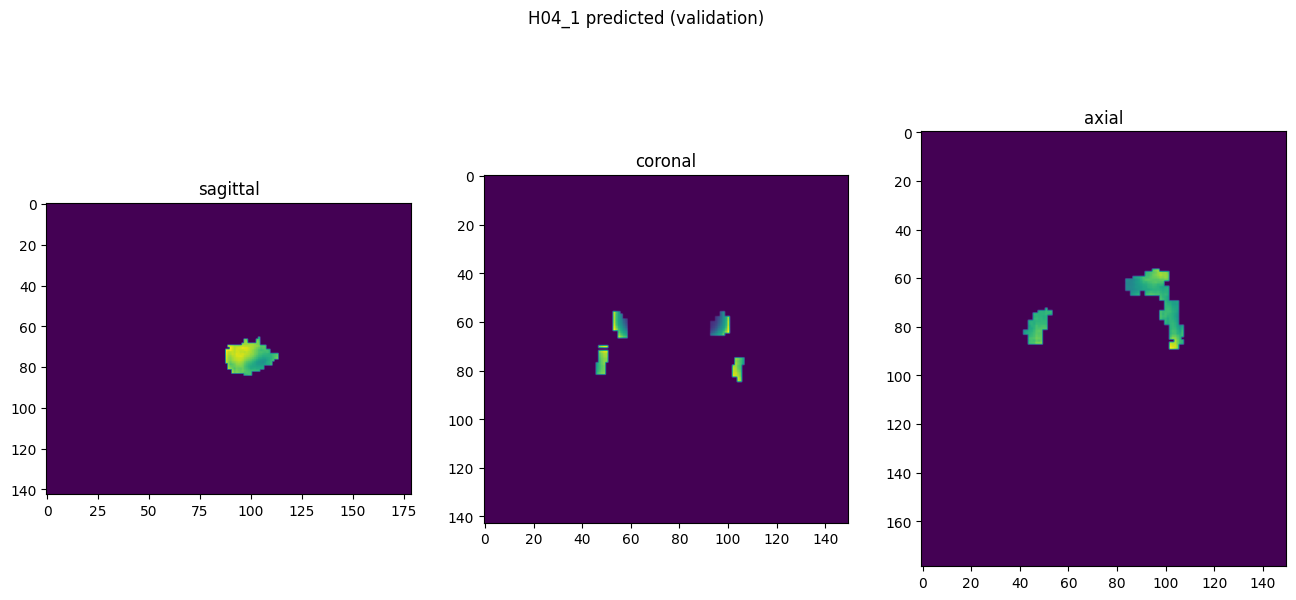

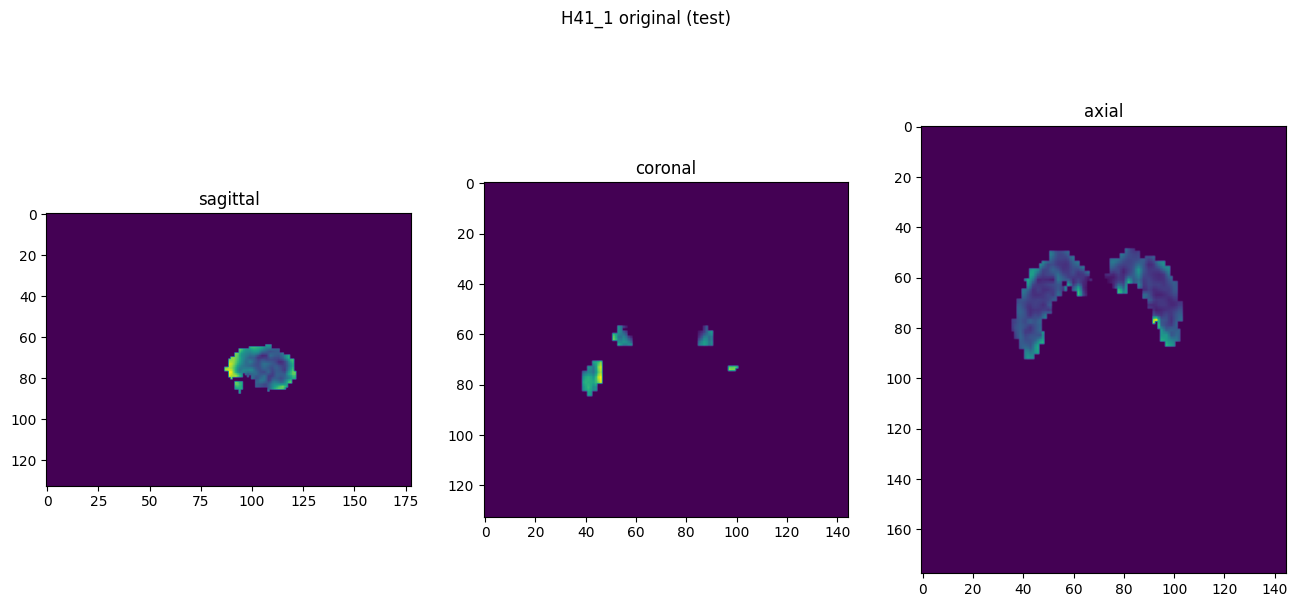

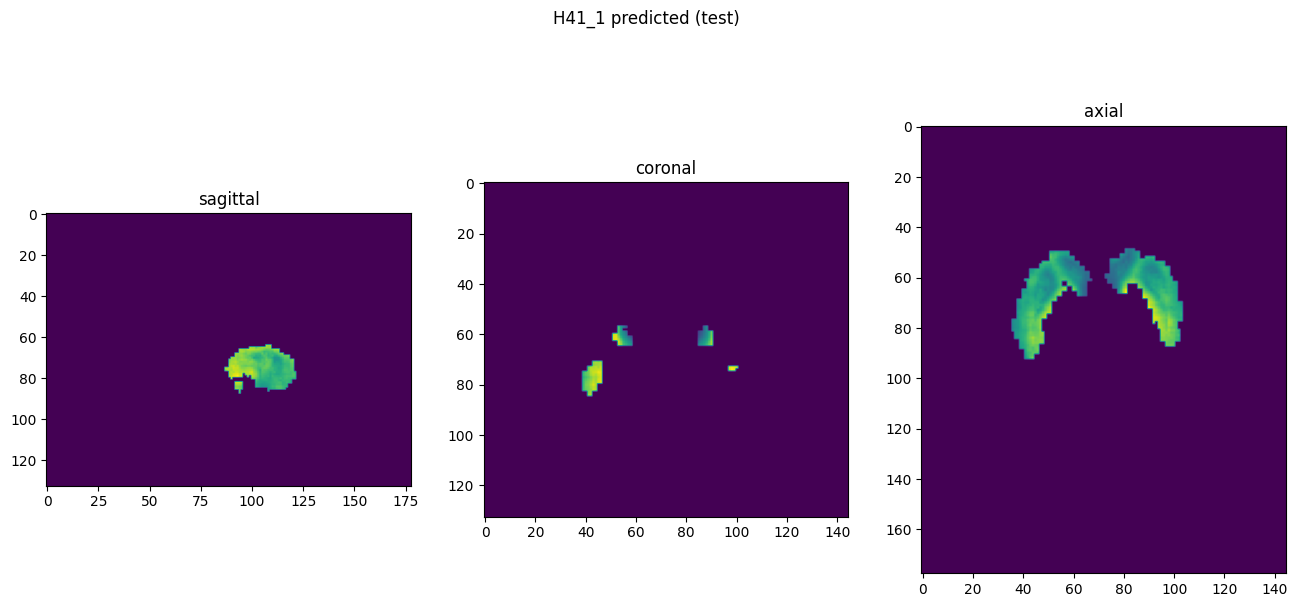

In [10]:
showResults(model, gen, threshold=None, background=False)